In [ ]:
import numpy as np
from PIL import Image as im
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Layer
from tensorflow.keras import initializers, regularizers, constraints
import keras 

In [ ]:
def showImage(arr):
    plt.imshow(arr, cmap = 'gray')
    plt.show()

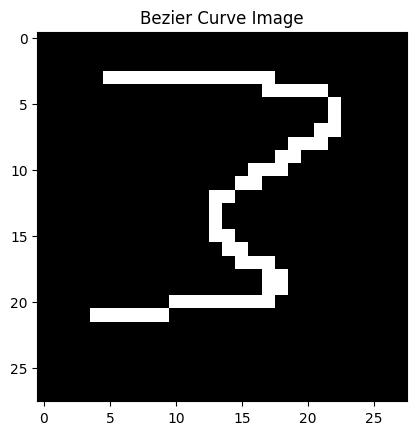

In [130]:
class BezierCurveLayer(tf.keras.layers.Layer):
    def __init__(self, num_control_points, img_acc, **kwargs):
        super(BezierCurveLayer, self).__init__(**kwargs)
        self.num_control_points = num_control_points
        self.img_acc = img_acc
        self.t = tf.linspace(0.0, 1.0, self.img_acc)
        self.bernstein = self._compute_bernstein()
    def _compute_bernstein(self):
        def binomial_coefficient(n, k):
            return tf.exp(tf.math.lgamma(tf.cast(n + 1, dtype=tf.float32)) - tf.math.lgamma(tf.cast(k + 1, dtype=tf.float32)) - tf.math.lgamma(tf.cast(n - k + 1, dtype=tf.float32)))
        
        def bernstein_polynomial(n, k, t):
            return binomial_coefficient(n, k) * tf.pow(t, tf.cast(k, dtype=tf.float32)) * tf.pow(1 - t, tf.cast(n - k, dtype=tf.float32))
        bernstein = tf.stack([bernstein_polynomial(self.num_control_points - 1, k, self.t) for k in range(self.num_control_points)], axis=-1)
        return tf.transpose(bernstein)
    
    def build(self, input_shape):
        super(BezierCurveLayer, self).build(input_shape)

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        control_points = tf.reshape(inputs, [batch_size, 2, self.num_control_points])
        bezier_curve = tf.matmul(control_points[0,:,:], self.bernstein)
        bez = tf.transpose(bezier_curve)
        scaled_bez = tf.cast(bez*28,tf.int32)


        updates = tf.ones((tf.shape(scaled_bez)[0],), dtype=tf.int32)
        image_shape = (28, 28)
        linear_indices = scaled_bez[:, 0] * image_shape[1] + scaled_bez[:, 1]

        image_flat = tf.scatter_nd(indices=tf.expand_dims(linear_indices, 1), updates=updates, shape=[image_shape[0] * image_shape[1]])
        image_flat = tf.minimum(image_flat, 1)

        image = tf.transpose(tf.reshape(image_flat, image_shape))
        return image


    def compute_output_shape(self, input_shape):
        return (input_shape[0], 28, 28)


control_points = tf.reshape(tf.convert_to_tensor([[0.162,1.387,0.166,-0.364,1.97,0.184], [0.753,0.76,0.446,0.623,0.1,0.133]]), (1,12))
bezier_layer = BezierCurveLayer(6, img_acc=200)
output_image = bezier_layer(control_points)

# Plot the output image
plt.imshow(output_image, cmap='gray')
plt.title('Bezier Curve Image')
plt.show()

train_im = output_image


In [ ]:
showImage(train_im)

Model: "functional_95"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_48 (InputLayer)     │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_108 (Dense)               │ (None, 256)            │        25,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_109 (Dense)               │ (None, 12)             │         3,084 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bezier_curve_layer_95           │ (None, 28, 28)         │             0 │
│ (BezierCurveLayer)              │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,940 (113.05 KB)

 Trainable params: 28,940 (113.05 KB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


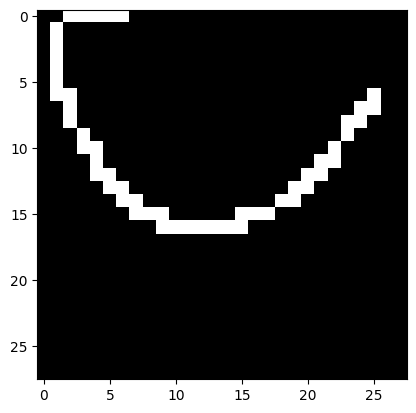

In [132]:
from keras.layers import Dense, Input, Reshape
from keras.models import Model

def define_generator(latent_dim):
    input_layer = Input(shape=(latent_dim,))
    x = Dense(256, activation='relu')(input_layer)
    x = Dense(12, activation='relu')(x)
    # x = Reshape((1,30))(x)
    x = BezierCurveLayer(6, img_acc=200)(x)
    
    output_im = x
    
    # Model
    model = Model(input_layer, output_im)
    return model
generator = define_generator(latent_dim=100)
generator.summary()

a = np.random.rand(1,100)
showImage(generator.predict(a))

In [ ]:
print(train_im)